In [1]:
%%markdown

# Parsec Traces

5 Programs




# Parsec Traces

5 Programs



In [2]:
import sveCacheSim as sim
import CacheModels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import importlib
importlib.reload(sim)
pass
import os

In [3]:
# Paths
os.chdir('/storage/home/hhive1/plavin3/data/ModelSwapping')
DATADIR = '/storage/home/hhive1/plavin3/scratch/DataV5/'

In [4]:
# Params
SIZE    = 'simdev'

In [5]:
# Available Choices for parsec traces
app_names        = ['blackscholes', 'bodytrack', 'ferret', 'fluidanimate', 'freqmine']
parsec_sizes     = ['simdev', 'simsmall']
models           = ['BASE', 'FR', 'M4', 'M8', 'ALL', 'ACC']
suffixes         = ['data', 'model']

meabo_sizes      = ['small', 'medium', 'large']

In [6]:
# Represents a single data or model file. The memory can be repeatedly freed and reloaded with free() and reload().

class ParsecFile:
    def __init__(self, app, size, model, suffix, openFile=False):
        if app not in app_names:
            raise ValueError('ParsecFile.init: app [{}] invalid'.format(app))
        if size not in parsec_sizes:
            raise ValueError('ParsecFile.init: size [{}] invalid'.format(size))
        if model not in models:
            raise ValueError('ParsecFile.init: model [{}] invalid'.format(model))
        if suffix not in suffixes:
            raise ValueError('ParsecFile.init: suffix [{}] invalid'.format(suffix))
        
        self.object    = None 
        self.filename  = DATADIR + app + '-' + size + '-' + model + '-' + suffix + '.pkl'
        self.shortname = os.path.splitext(os.path.basename(os.path.normpath(self.filename)))[0]
        self.app       = app
        self.size      = size
        self.model     = model
        self.suffix    = suffix
        self.file      = None
        
        if not os.path.exists(self.filename):
            raise Exception('Error in ParsecFile.init: file [{}] not found'.format(self.filename))
            
        if openFile:
            self.object= sim.load_object(self.filename)
    
    def load(self):
        self.object= sim.load_object(self.filename)
    
    def free(self):
        if self.object != None:
            del self.object
            self.object = None
            
class MeaboFile(ParsecFile):
    def __init__(self, size, model, suffix, openFile=False):
        if size not in meabo_sizes:
            raise ValueError('MeaboFile.init: size [{}] invalid'.format(size))
        if model not in models:
            raise ValueError('MeaboFile.init: model [{}] invalid'.format(model))
        if suffix not in suffixes:
            raise ValueError('MeaboFile.init: suffix [{}] invalid'.format(suffix))
        
        self.object    = None 
        self.filename  = DATADIR + 'meabo_' + size + '-' + model + '-' + suffix + '.pkl'
        self.shortname = os.path.splitext(os.path.basename(os.path.normpath(self.filename)))[0]
        self.size      = size
        self.model     = model
        self.suffix    = suffix
        self.file      = None
        self.app       = 'meabo'
        
        if not os.path.exists(self.filename):
            raise Exception('Error in MeaboFile.init: file [{}] not found'.format(self.filename))
            
        if openFile:
            self.object= sim.load_object(self.filename)
            

In [7]:
# Check that all of our files exist
missing  = False
allfiles = []
for app in app_names:
    for m in models:
        for s in suffixes:
            try:
                allfiles.append(ParsecFile(app, SIZE, m, s))
            except:
                missing = True
                print('   Couldnt find {} {} {} {}'.format(app, SIZE, m, s))

if missing: 
    print('Some parsec files weren\'t found!')
else:
    print('Found all parsec files!')
    
missing  = False
filesaltblack = []
for app in app_names:
    if app is 'blackscholes':
        sz = 'simsmall'
    else:
        sz = 'simdev'
    for m in models:
        for s in suffixes:
            try:
                filesaltblack.append(ParsecFile(app, sz, m, s))
            except:
                missing = True
                print('   Couldnt find {} {} {} {}'.format(app, SIZE, m, s))

if missing: 
    print('Some parsec-alt files weren\'t found!')
else:
    print('Found all parsec-alt files!')
                
missing  = False
meabofiles = []
for sz in meabo_sizes:
    for m in models:
        for s in suffixes:
            try:
                meabofiles.append(MeaboFile(sz, m, s))
            except:
                missing = True
                print('   Couldnt find {} {} {}'.format(sz, m, s))

if missing: 
    print('Some meabo files weren\'t found!')
else:
    print('Found all meabo files!')


    
FILESETNAME = 'meabo' # should be either 'simdevaltblack' or 'simdev' or 'meabo'

if FILESETNAME is 'simdevaltblack':
    fileset = filesaltblack
elif FILESETNAME is 'simdev':
    fileset = allfiles
elif FILESETNAME is 'meabo':
    fileset = meabofiles
    meabosize = 'large'


Found all parsec files!
Found all parsec-alt files!
Found all meabo files!


In [10]:
def listize(a):
    if a and not isinstance(a, list):
        return [a]
    return a

def validate(val, gold):
    if val is None:
        return
    for v in val:
        if v not in gold:
            raise ValueError('{} is not a valid value'.format(v))
    
    
# Utility function for working with lists of data as opposed to loading all the data
# TODO: drop all this and use Dask
def subset(files, app=None, model=None, size=None, suffix=None):

    app    = listize(app)
    model  = listize(model)
    size   = listize(size)
    suffix = listize(suffix)
    
    validate(app, app_names)
    validate(size, parsec_sizes)
    validate(model, models)
    validate(suffix, suffixes)
    
    ret = files
    
    if app is not None:
        files = ret
        ret = []
        for f in files:
            if f.app in app:
                ret.append(f)            

    if model is not None:
        files = ret
        ret   = []
        for f in files:
            if f.model in model:
                ret.append(f)
        
    if size is not None:
        files = ret
        ret   = []
        for f in files:
            if f.size in size:
                ret.append(f)
                
    if suffix is not None:
        files = ret
        ret   = []
        for f in files:
            if f.suffix in suffix:
                ret.append(f)
    
                
    if len(ret) == 0:
        raise Exception('subset() refuses to return an empty list')
        
    return ret

def print_filenames(files):
    files = listize(files)
    for f in files:
        print(f.shortname)
        
                
print_filenames(subset(fileset, suffix='data'))
#print(subset(allfiles, app='bodytrack', model='M4', suffix='data'))

meabo_small-BASE-data
meabo_small-FR-data
meabo_small-M4-data
meabo_small-M8-data
meabo_small-ALL-data
meabo_small-ACC-data
meabo_medium-BASE-data
meabo_medium-FR-data
meabo_medium-M4-data
meabo_medium-M8-data
meabo_medium-ALL-data
meabo_medium-ACC-data
meabo_large-BASE-data
meabo_large-FR-data
meabo_large-M4-data
meabo_large-M8-data
meabo_large-ALL-data
meabo_large-ACC-data


In [125]:
%%markdown

### Phase Trace Object
We first need to grab the phase trace object from the stats of our simulation. It is stored in `stats_*.phase_trace`. This object
has type `PhaseTrace` which is defined in `PhaseDetector.py` and includes 4 fields.

* `trace`: The phase assigned to each interval. -1 represents an interval not identified as part of a phase. 
* `nphases`: The number of unique phases identified.
* `phase_count`: A list of length nphases where phase_count[i] is the number of intervals assigned to phase i
* `phase_unique`: A list of length nphases where phase_unique[i] is the number of times phase i was entered

Let's take a look at these for the 'large' trace. 


### Phase Trace Object
We first need to grab the phase trace object from the stats of our simulation. It is stored in `stats_*.phase_trace`. This object
has type `PhaseTrace` which is defined in `PhaseDetector.py` and includes 4 fields.

* `trace`: The phase assigned to each interval. -1 represents an interval not identified as part of a phase. 
* `nphases`: The number of unique phases identified.
* `phase_count`: A list of length nphases where phase_count[i] is the number of intervals assigned to phase i
* `phase_unique`: A list of length nphases where phase_unique[i] is the number of times phase i was entered

Let's take a look at these for the 'large' trace. 


In [30]:
def phase_summary(file):
    file.load()
    
    tr=file.object.phase_trace
    print(file.shortname, ':')
    print('  Identified', tr.nphases, 'phases')
    print('  Number of intervals assigned to each phase', tr.phase_count)
    #print('  Number of times each phase was entered', tr.phase_unique)
    file.free()
    
for file in subset(fileset, model='BASE', suffix='data'):
    phase_summary(file)
#for tr in slu.keys():
#    if 'BASE' in slu[tr].keys():
#        phase_summary(tr, slu[tr]['BASE'])

meabo_small-BASE-data :
  Identified 6 phases
  Number of intervals assigned to each phase [3, 11, 43, 21, 8, 32]
meabo_medium-BASE-data :
  Identified 6 phases
  Number of intervals assigned to each phase [3, 11, 77, 47, 21, 69]
meabo_large-BASE-data :
  Identified 7 phases
  Number of intervals assigned to each phase [3, 9, 45, 114, 231, 112, 337]


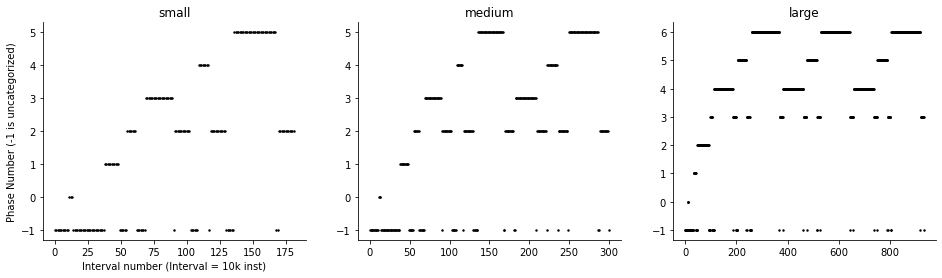

In [23]:
def plot_trace(ax, label, trace, axis_labels):
    ax.scatter([*range(len(trace))], trace,s=2, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(label)
    ax.set_yticks([-1, *range(max(trace)+1)])
    if axis_labels:
        ax.set_ylabel('Phase Number (-1 is uncategorized)')
        ax.set_xlabel('Interval number (Interval = 10k inst)')

local_files = subset(fileset, model='BASE', suffix='data')
fig, ax = plt.subplots(1, len(local_files), figsize=(16,4))

for idx, file in enumerate(local_files):
    file.load()
    if FILESETNAME == 'meabo':
        label = file.size
    else:
        label = file.app
    plot_trace(ax[idx], label,  file.object.phase_trace.trace,  idx == 0)
    file.free()
    
plt.savefig(DATADIR+'/plots/phase-traces-{}.svg'.format(FILESETNAME))
plt.show()

In [24]:
def get_acc(st1, st2, phase):
    # t1 is assumed to be from the base cache
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    num_correct = np.sum(np.equal(t1_hits, t2_hits))
    acc = num_correct / len(t1_hits)
    
    return acc
    
    
def get_stats(base, others):
    nphases = base.phase_trace.nphases
    name_map={'FR':'Fixed Rate', 'M4': 'Markov 4', 'M8':'Markov 8', 'ALL':'All', 'ACC':'ACC'}
    data = {}
    for file in others:
        file.load()
        _acc = []
        for i in range(nphases):
            _acc.append(get_acc(base, file.object, i))
        data[name_map[file.model]] = _acc
        file.free()
    return pd.DataFrame(data)

acc = {}

#local_files = subset(allfiles, suffix='data')
#print_filenames(local_files)

for app in app_names:
    print('->{} accuracy'.format(app))
    base   = subset(fileset, model='BASE', app=app, suffix='data')
    if len(base) > 1:
        raise Exception('Too man files in list')
    base = base[0]
    others = subset(fileset, model=['FR', 'M4', 'M8', 'ALL', 'ACC'], app=app, suffix='data')
    
    base.load()
    acc[app] = get_stats(base.object, others)
    print(acc[app])
    print()
    base.free()

sim.save_object(acc, DATADIR+'intermediate/acc-{}.pkl'.format(FILESETNAME))


->meabo accuracy


Exception: Too man files in list

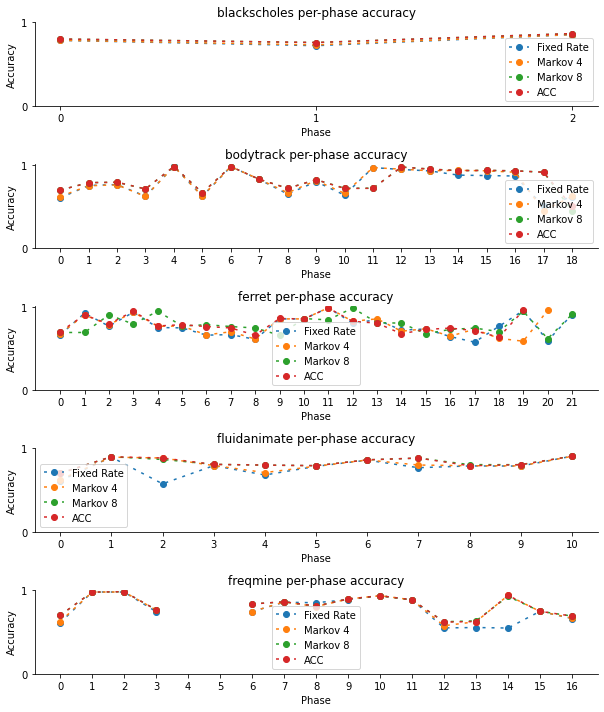

In [218]:
nn=1
name_map={'FR':'Fixed Rate', 'M4': 'Markov 4', 'M8':'Markov 8', 'ALL':'All', 'ACC':'ACC'}

local_models = [name_map[x] for x in ['FR', 'M4', 'M8','ACC']]
def acc_plot(ax, acc, tr):
    df = acc[tr]
    
    # Subset models
    df = df[local_models]
    ny = len(df)
    #ax=plt.gca()
    df.plot(xticks=[*range(0,ny,1)],
            yticks=[i/nn for i in range(0,nn+1)], 
                 title='{} per-phase accuracy'.format(tr),ax=ax, 
                 marker='o', linestyle=(0, (2,4)))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Phase')
    #ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    cmap = plt.get_cmap("tab10")
    #ax.text( x=ny-1+.1, y=df['Fixed Rate'][ny-1], s='Fixed Rate', color=cmap(0))
    #ax.text( x=4.1, y=df['Markov 4'][ny-1], s='Markov 4', color=cmap(1))
    #ax.text( x=4.1, y=df['Markov 8'][ny-1], s='Markov 8', color=cmap(2))
    plt.tight_layout()

fig, ax = plt.subplots(len(app_names), 1, figsize=(8.5,10))
for idx, tr in enumerate(app_names):
    acc_plot(ax[idx], acc, tr)
    #acc_plot(acc, slu, 'steam2')
plt.savefig(DATADIR+'/plots/per-phase-accuracy-{}.svg'.format(FILESETNAME))

blackscholes
bodytrack
ferret
fluidanimate
freqmine


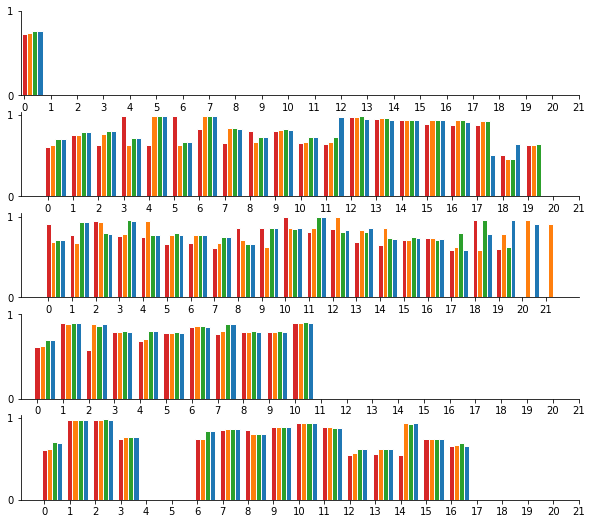

In [7]:
nn=1
maxidx=len(slu.keys())
barwidth=.2

colors = plt.cm.get_cmap('tab10').colors
colormap={'All': colors[0], 'Markov 4':colors[1], 'Markov 8':colors[2], 'Fixed Rate':colors[3]}


def acc_plot(ax, acc, slu, tr, idx):
    df = acc[tr]
    ny = slu[tr]['BASE'].phase_trace.nphases
    #ax=plt.gca()
    print(tr)
    for idx,k in enumerate(acc[tr]):
        bars=acc[tr][k]
        r = np.arange(len(bars)) + barwidth*idx
        ax.bar(r, bars, color=colormap[k], width=barwidth, edgecolor='white', label='var1')

    #ax.xticks([r + barwidth for r in range(len(bars))], ['A', 'B', 'C', 'D'])
    ax.set_yticks([0,1])
    ax.set_xticks([*range(0,22,1)])
    

    
    #df.plot(xticks=[*range(0,ny,1)],
    #        yticks=[i/nn for i in range(0,nn+1)], 
    #             title='{}'.format(tr),ax=ax, 
    #             marker='o', linestyle=(0, (2,4)))
    #if idx == maxidx - 1:
    #    ax.set_ylabel('Accuracy')
    #    ax.set_xlabel('Phase')

    #ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #cmap = plt.get_cmap("tab10")

    #plt.tight_layout()

fig, ax = plt.subplots(len(slu.keys()), 1, figsize=(10,9))
for idx, tr in enumerate(slu.keys()):
    if 'BASE' in slu[tr].keys():
        acc_plot(ax[idx], acc, slu, tr, idx)
    #acc_plot(acc, slu, 'steam2')
#plt.savefig('plots/per-phase-accuracy.svg')

In [219]:
def pct_change(new, old):
    ret = []
    for i,v in enumerate(new):
        ret.append((v - old[i])/abs(old[i])*100)
    return ret


dd = []
for app in app_names:
    print('Working on {}'.format(app))
    base = subset(fileset, app=app, model='BASE')[0]
    base.load()
    for model in ['FR', 'M4', 'M8', 'ALL', 'ACC']:
        file = subset(fileset, app=app, model=model)[0]
        file.load()

        new = file.object.hitcount
        old = base.object.hitcount
    
        new.append(file.object.total_cycles)
        old.append(base.object.total_cycles)
                   
        pct = [app, model, *pct_change(new, old)]
        dd.append(pct)

        file.free()
    base.free()
    
pct_change_df = pd.DataFrame(dd, columns=['app', 'model', 'L1', 'L2', 'L3', 'cycles'])
print(pct_change_df)
sim.save_object(pct_change_df, DATADIR+'/intermediate/pct_change-{}.pkl'.format(FILESETNAME))

Working on blackscholes
Working on bodytrack
Working on ferret
Working on fluidanimate
Working on freqmine
             app model        L1         L2         L3     cycles
0   blackscholes    FR  0.142755  59.984234 -85.226123 -43.703494
1   blackscholes    M4  0.081033  57.510326 -81.512839 -41.299360
2   blackscholes    M8 -0.185856  52.866413 -73.386895 -35.394945
3   blackscholes   ALL -0.213015  53.430998 -73.879713 -35.578503
4   blackscholes   ACC -0.182279  52.864388 -73.439449 -35.415795
5      bodytrack    FR  0.063947  90.610497 -39.477542 -38.487638
6      bodytrack    M4 -0.144719  91.284288 -38.334284 -36.767313
7      bodytrack    M8 -0.448652  84.064544 -31.873645 -30.930248
8      bodytrack   ALL -0.383725  82.632478 -30.985314 -31.009528
9      bodytrack   ACC -0.365063  82.154396 -32.246690 -30.886170
10        ferret    FR  1.208474  37.032825 -53.420955 -31.134320
11        ferret    M4  1.484294  32.753992 -51.722209 -29.780169
12        ferret    M8  0.365291  3

In [220]:
#pct_change_df = sim.load_object(DATADIR+'/intermediate/pct_change.pkl')

print('Grouped By Model')
for m in ['FR', 'M4', 'M8', 'ALL', 'ACC']:
    print(pct_change_df[pct_change_df['model']==m])
    
print()
print('Grouped By Apps')
print(pct_change_df)
#for app in app_names:
#    print(pct_change_df[pct_change_df['app']==app])
        


Grouped By Model
             app model        L1         L2         L3     cycles
0   blackscholes    FR  0.142755  59.984234 -85.226123 -43.703494
5      bodytrack    FR  0.063947  90.610497 -39.477542 -38.487638
10        ferret    FR  1.208474  37.032825 -53.420955 -31.134320
15  fluidanimate    FR  3.756862  -2.406898 -83.053985 -37.736457
20      freqmine    FR  1.225235  17.419305 -45.085833 -21.175781
             app model        L1         L2         L3     cycles
1   blackscholes    M4  0.081033  57.510326 -81.512839 -41.299360
6      bodytrack    M4 -0.144719  91.284288 -38.334284 -36.767313
11        ferret    M4  1.484294  32.753992 -51.722209 -29.780169
16  fluidanimate    M4  3.721808  -2.246124 -83.887411 -37.180865
21      freqmine    M4  0.991521  17.443559 -44.505145 -17.977543
             app model        L1         L2         L3     cycles
2   blackscholes    M8 -0.185856  52.866413 -73.386895 -35.394945
7      bodytrack    M8 -0.448652  84.064544 -31.873645 -30.

In [94]:
%%markdown

## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


In [92]:
interval_len = 10000
def acc_over_time(st1, st2, phase):
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    nintervals = int(len(t1_hits) // interval_len)-1
    
    acc = []
    
    for i in range(nintervals):
        start = i*interval_len
        end   = (i+1)*interval_len
        t1_hits_rest = t1_hits[start:end]
        t2_hits_rest = t2_hits[start:end]
    
        num_correct = np.sum(np.equal(t1_hits_rest, t2_hits_rest))
        acc.append(num_correct / interval_len)
    
    return acc

nphases = stats['base'].phase_trace.nphases
name_map={'fr':'Fixed Rate', 'm4': 'Markov 4', 'm8':'Markov 8', 'all':'All'}
all_df = {}
for i in range(nphases):
    data = {}
    for name in stats:
        if name is 'base':
            continue
        data[name_map[name]] = acc_over_time(stats['base'], stats[name], i)
    data_df = pd.DataFrame(data)    
    all_df[i] = data_df


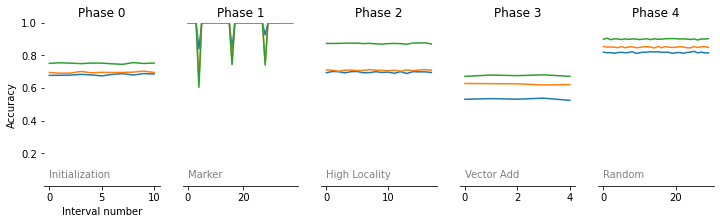

In [120]:
pretty=['Initialization', 'Marker', 'High Locality', 'Vector Add', 'Random']
def acc_over_time_plot(ax, approx, m4, m8, phase):
    ax.plot(approx, label='Fixed Rate')
    ax.plot(m4, label='Markov 4')
    ax.plot(m8, label='Markov 8')    
    ax.set_ylim((0,1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.set_title('Phase {}'.format(phase))
    ax.text(x=0, y=.05, s=pretty[phase], color='grey')
    if phase == 0:
        ax.set_ylabel('Accuracy')
        ax.get_yaxis().set_ticks([.2, .4, .6, .8, 1.])
        ax.set_xlabel('Interval number')
    if phase == 4:
        pass
        #ax.legend(loc=10) ##UNCOMMENT ME FOR LEGEND

fig, ax = plt.subplots(1, 5, figsize=(12,3), squeeze=False)
for phase in range(5):    
    acc_over_time_plot(ax[0,phase], 
          all_df[phase]['Fixed Rate'],
          all_df[phase]['Markov 4'],
          all_df[phase]['Markov 8'],
          phase)
#plt.savefig('plots/acc-over-time.svg')
plt.show()


In [95]:
%%markdown

## Accuracy as a function of Model Size

This is just a fun little plot. 


## Accuracy as a function of Model Size

This is just a fun little plot. 


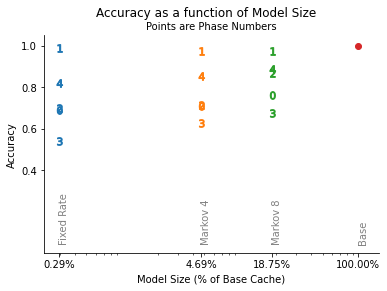

In [121]:
bs=8192
sz = {'base':1, 'fr':24/bs, 'm4':(3 * (4 * 4) * 8)/bs, 'm8':(3 * (8 * 8) * 8)/bs}

fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
for i in range(5):
    ax.scatter([sz['fr']], accuracy_df['Fixed Rate'][i], marker='${}$'.format(i), color=cmap(0), s=60)
for i in range(5):
    ax.scatter([sz['m4']], accuracy_df['Markov 4'][i], marker='${}$'.format(i), color=cmap(1), s=60)
for i in range(5):
    ax.scatter([sz['m8']], accuracy_df['Markov 8'][i], marker='${}$'.format(i), color=cmap(2), s=60)
ax.scatter(1,1,  color=cmap(3))
ax.set_xscale('log')


labs=np.float64([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])*100
ax.get_xaxis().set_ticks([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])
ax.set_xticklabels(['{:.2f}%'.format(labs[i]) for i in range(4)])

ax.get_yaxis().set_ticks([.4,.6, .8, 1])

ax.set_xlabel('Model Size (% of Base Cache)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1.05)
ax.set_xlim(0,1.5)
ax.text(x=labs[0]/100, y=.05, s='Fixed Rate', rotation=90, color='grey')
ax.text(x=labs[1]/100, y=.05, s='Markov 4', rotation=90, color='grey')
ax.text(x=labs[2]/100, y=.05, s='Markov 8', rotation=90, color='grey')
ax.text(x=labs[3]/100, y=.05, s='Base', rotation=90, color='grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Points are Phase Numbers', size=10)
fig.suptitle('Accuracy as a function of Model Size')

#plt.savefig('plots/acc_vs_modelsize.svg')

plt.show()

In [101]:
%%markdown

## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


In [111]:
def index(array, item):
    for idx, val in enumerate(array):
        if val == item:
            return idx
    return -1

def rightshift(val: np.uint64, shift: np.uint64) -> np.uint64:
    return val >> shift

def reuse(trace, shift, outfile=None):
    stack = np.array([], dtype=np.int64)
    out = []
    for i in tqdm(range(len(trace))):
        addr = rightshift(trace[i], np.uint64(shift)) # Cache line
        idx = index(stack, addr)
        if idx == -1:
            stack = np.insert(stack, 0, addr)
        else:
            out.append(idx)
            stack = np.delete(stack, idx)
            stack = np.insert(stack, 0, addr)

    if outfile is not None:
        save_object(out, outfile)
        print('Wrote reuse trace to: {}'.format(outfile))
        
    return out


In [113]:
reuse_perphase_base    = {}
reuse_perphase_approx  = {}
reuse_perphase_markov4 = {}
reuse_perphase_markov8 = {}
gran=6

def get_addrs(data, phase):
    df = pd.DataFrame(data)
    return np.array(df[df['phase']==phase]['addr'], dtype=np.uint64)

for phase in range(0,5):
    reuse_perphase_base[phase] = reuse(get_addrs(stats['base'].cache_trace[1], phase), gran)
    reuse_perphase_approx[phase] = reuse(get_addrs(stats['fr'].cache_trace[1], phase), gran)
    reuse_perphase_markov4[phase] = reuse(get_addrs(stats['m4'].cache_trace[1], phase), gran)
    reuse_perphase_markov8[phase] = reuse(get_addrs(stats['m8'].cache_trace[1], phase), gran)

100%|██████████| 4826/4826 [00:02<00:00, 2337.25it/s]
0it [00:00, ?it/s]
100%|██████████| 36357/36357 [00:02<00:00, 17691.74it/s]


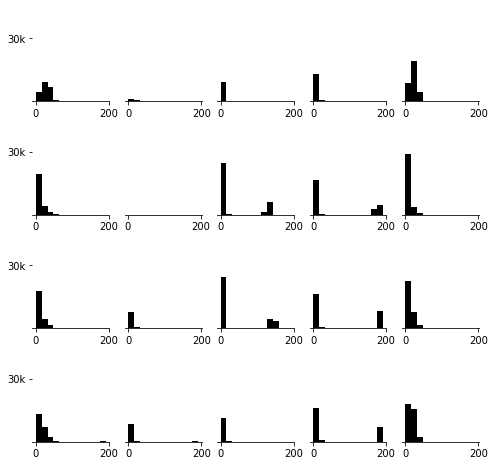

In [123]:
binwidth=16
#maxbin={1:50, 2:850, 3:225, 4:50}
maxbin={0:200,1:200, 2:200, 3:200, 4:200}

yl=45000
ylim={0:yl,1:yl, 2:yl, 3:yl, 4:yl}


def bins(data, binwidth, maxbin):
    #return range(min(data), min(maxbin, max(data) + binwidth), binwidth)
   # print(data)
    return range(min(data), maxbin, binwidth)

def plot(ax, data, title, phase):
    if not data:
        data = [1]
    ax.hist(data, bins=bins(data, binwidth, maxbin=maxbin[phase]), color='black')
    ax.set_ylim((0,ylim[phase]))
    #ax.suptitle(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    if phase == 0:
        ax.get_yaxis().set_ticks([30000])
        ax.set_yticklabels(['30k'])
    
#plot(reuse_perphase_base[1], 'Base Cache', maxbin=maxbin[1])
#plot(reuse_perphase_approx[1], 'Fixed Rate Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov4[1], '4-State Markov Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov8[1], '8-State Markov Cache', maxbin=maxbin[1])

#i = 1

fig, ax = plt.subplots(4, 5, figsize=(8,8))
for i in range(5):
    #phase = i+1
    phase=i
    
    plot(ax[0,i], reuse_perphase_base[phase], 'Base Cache', phase)
    plot(ax[1,i], reuse_perphase_approx[phase], 'Fixed Rate Cache', phase)
    plot(ax[2,i], reuse_perphase_markov4[phase], '4-State Markov Cache', phase)
    plot(ax[3,i], reuse_perphase_markov8[phase], '8-State Markov Cache', phase)

#plt.savefig('plots/locality_per_phase.svg')
plt.show()